# Section 6 Analysis: Basic Retrieval vs Reranking

This notebook analyzes the results from section 6 experiments, which compare basic retrieval with reranking:

## Experiments Being Compared

1. **Basic Retrieval**: similarity_search(k=5) → direct to LLM
2. **Reranking**: similarity_search(k=10) → rerank by relevance → top 3 to LLM

## Research Questions

- Does reranking reduce "Missed Top Rank" and "Not in Context" failures?
- How does reranking affect latency and response quality?
- What are the tradeoffs between basic retrieval and reranking?


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from rag.questions import BASELINE_QUESTIONS

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## Load Experiment Results


In [2]:
# Load all experiment results
basic_file = "results/chunk1200_overlap300_k5_ollama-ollama_llama3.2_nomic-embed-text.csv"
reranking_file = "results/chunk1200_overlap300_k10_reranking_ollama-ollama_llama3.2_nomic-embed-text.csv"

# Try to load files (some may not exist if experiments failed)
dfs = {}
for name, file in [
    ("Basic Retrieval", basic_file),
    ("Reranking", reranking_file)
]:
    if os.path.exists(file):
        dfs[name] = pd.read_csv(file)
        print(f"✓ Loaded {name}: {file} ({len(dfs[name])} questions)")
    else:
        print(f"✗ Not found: {file}")


✓ Loaded Basic Retrieval: results/chunk1200_overlap300_k5_ollama-ollama_llama3.2_nomic-embed-text.csv (4 questions)
✓ Loaded Reranking: results/chunk1200_overlap300_k10_reranking_ollama-ollama_llama3.2_nomic-embed-text.csv (4 questions)


## Comparison: Basic Retrieval vs Reranking


COMPARISON: Basic Retrieval vs Reranking

Configuration:
  Basic Retrieval: k=5 → direct to LLM
  Reranking: k=10 → rerank → top 3 to LLM
  Chunk Size: 1200

Runtime Metrics:
  Basic Retrieval - Indexing Time: 13.75s
  Reranking - Indexing Time: 11.85s

  Basic Retrieval - Avg Response Time: 13.45s
  Reranking - Avg Response Time: 5.7s
  Latency Difference: -7.75s (-57.6%)


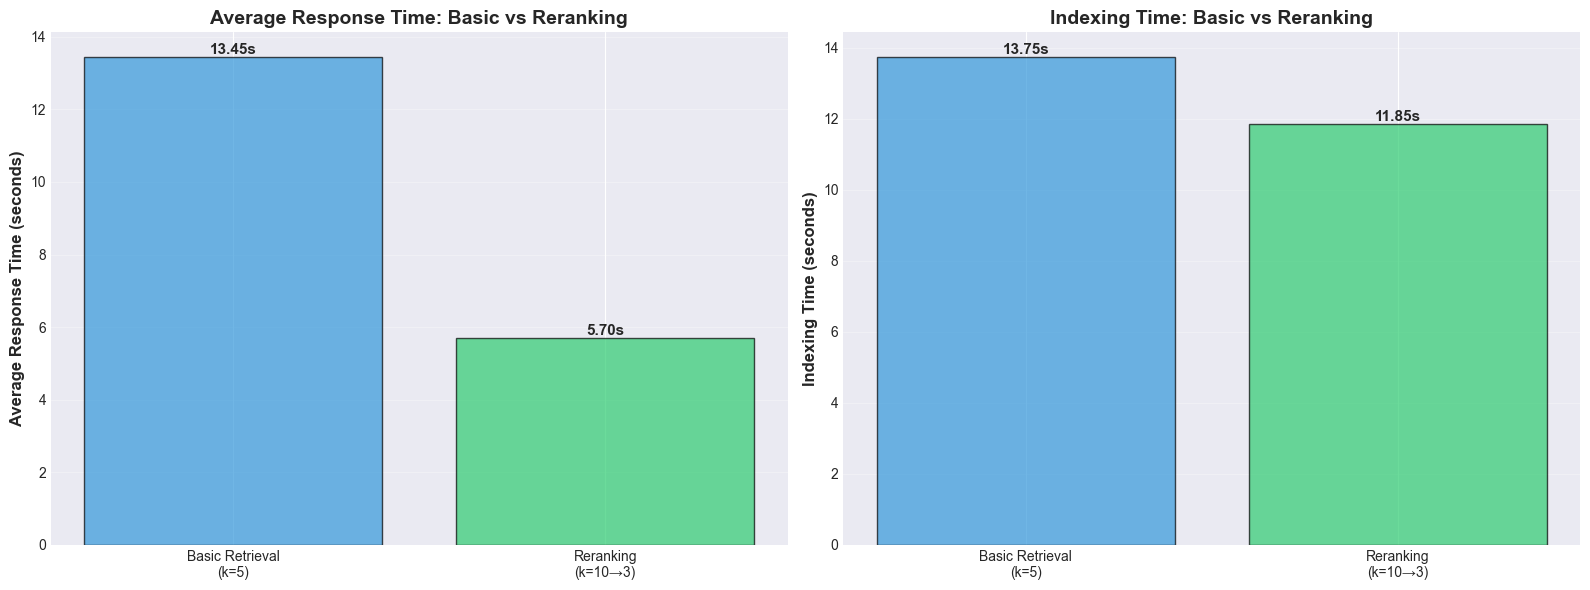

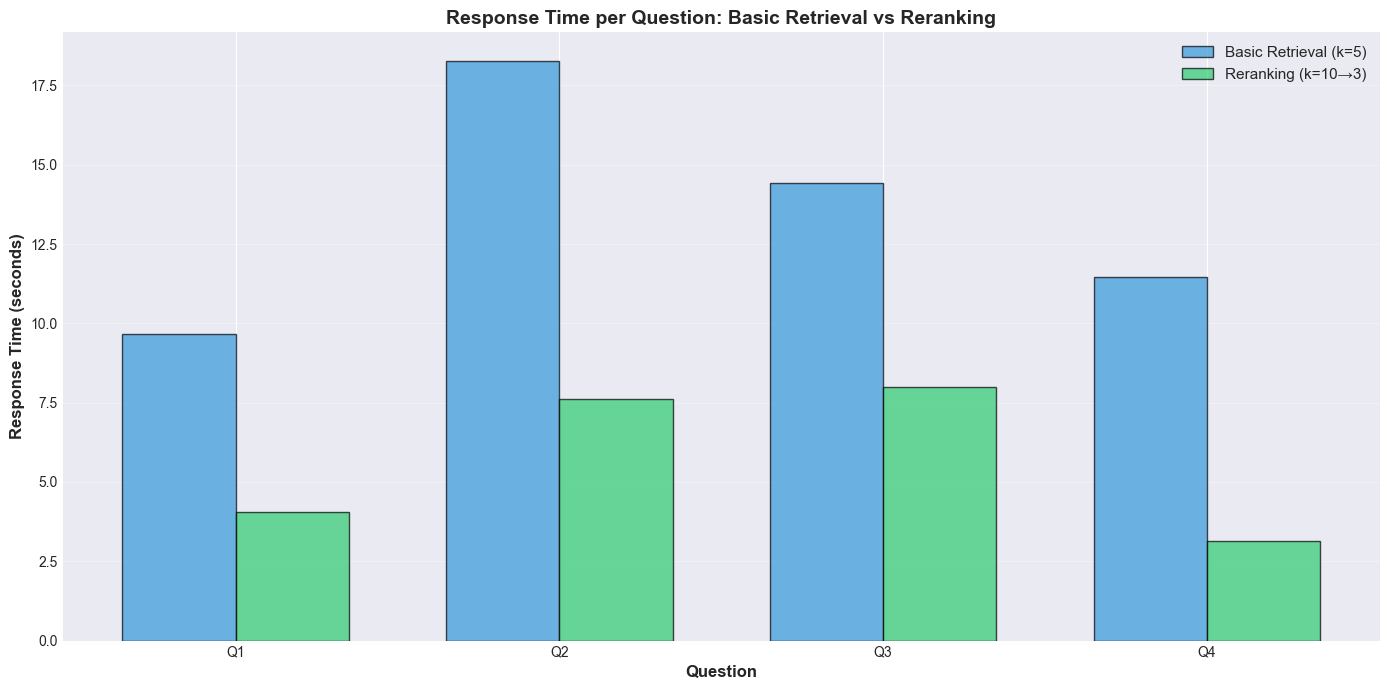


Response Quality Comparison (Manual Evaluation)

Reranking should reduce 'Missed Top Rank' and 'Not in Context' failures.
Evaluate whether reranking improves answer accuracy.

Question 1: What is Apache Iceberg? Explain in short.

Basic Retrieval Response:
Apache Iceberg is a table format that manages large, slow-changing collections of files in a distributed file system or key-value store. It allows for efficient and scalable storage, querying, and analysis of data.

Reranking Response:
Apache Iceberg is an open-source columnar storage format for big data. It's designed to provide fast and efficient scanning of large datasets, with features like serializable isolation, speed, and scalability. The key benefit is that it allows clients to handle job planning, reducing the load on a central metadata store.

--------------------------------------------------------------------------------

Question 2: How does Iceberg ensure that two writers do not overwrite each others ingestion results?

In [3]:
if "Basic Retrieval" in dfs and "Reranking" in dfs:
    print("="*80)
    print("COMPARISON: Basic Retrieval vs Reranking")
    print("="*80)
    
    df_basic = dfs["Basic Retrieval"]
    df_rerank = dfs["Reranking"]
    
    # Configuration comparison
    print("\nConfiguration:")
    print(f"  Basic Retrieval: k={df_basic.iloc[0]['Retrieval K']} → direct to LLM")
    print(f"  Reranking: k={df_rerank.iloc[0]['Retrieval K']} → rerank → top 3 to LLM")
    print(f"  Chunk Size: {df_basic.iloc[0]['Chunk Size']}")
    
    # Runtime comparison
    print("\nRuntime Metrics:")
    print(f"  Basic Retrieval - Indexing Time: {df_basic.iloc[0]['Indexing Time (s)']}s")
    print(f"  Reranking - Indexing Time: {df_rerank.iloc[0]['Indexing Time (s)']}s")
    
    print(f"\n  Basic Retrieval - Avg Response Time: {df_basic.iloc[0]['Average Response Time (s)']}s")
    print(f"  Reranking - Avg Response Time: {df_rerank.iloc[0]['Average Response Time (s)']}s")
    
    latency_diff = df_rerank.iloc[0]['Average Response Time (s)'] - df_basic.iloc[0]['Average Response Time (s)']
    latency_pct = (latency_diff / df_basic.iloc[0]['Average Response Time (s)']) * 100
    print(f"  Latency Difference: {latency_diff:.2f}s ({latency_pct:+.1f}%)")
    
    # Visualization: Performance Comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    strategies = ['Basic Retrieval\n(k=5)', 'Reranking\n(k=10→3)']
    avg_response_times = [
        df_basic.iloc[0]['Average Response Time (s)'],
        df_rerank.iloc[0]['Average Response Time (s)']
    ]
    indexing_times = [
        df_basic.iloc[0]['Indexing Time (s)'],
        df_rerank.iloc[0]['Indexing Time (s)']
    ]
    colors = ['#3498db', '#2ecc71']
    
    # Average Response Time
    bars1 = ax1.bar(strategies, avg_response_times, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Average Response Time (seconds)', fontsize=12, fontweight='bold')
    ax1.set_title('Average Response Time: Basic vs Reranking', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar, time in zip(bars1, avg_response_times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{time:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Indexing Time
    bars2 = ax2.bar(strategies, indexing_times, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Indexing Time (seconds)', fontsize=12, fontweight='bold')
    ax2.set_title('Indexing Time: Basic vs Reranking', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    for bar, time in zip(bars2, indexing_times):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{time:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Visualization: Response Times per Question
    fig, ax = plt.subplots(figsize=(14, 7))
    x = np.arange(len(df_basic))
    width = 0.35
    
    questions_short = [f"Q{i+1}" for i in range(len(df_basic))]
    basic_times = df_basic["Response Time (s)"].values
    rerank_times = df_rerank["Response Time (s)"].values
    
    bars1 = ax.bar(x - width/2, basic_times, width, label='Basic Retrieval (k=5)', 
                   color='#3498db', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, rerank_times, width, label='Reranking (k=10→3)', 
                   color='#2ecc71', alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Question', fontsize=12, fontweight='bold')
    ax.set_ylabel('Response Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('Response Time per Question: Basic Retrieval vs Reranking', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(questions_short)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Response quality comparison (manual evaluation)
    print("\n" + "="*80)
    print("Response Quality Comparison (Manual Evaluation)")
    print("="*80)
    print("\nReranking should reduce 'Missed Top Rank' and 'Not in Context' failures.")
    print("Evaluate whether reranking improves answer accuracy.")
    
    for idx, question in enumerate(BASELINE_QUESTIONS):
        print(f"\nQuestion {idx + 1}: {question}")
        print("\nBasic Retrieval Response:")
        print(df_basic.iloc[idx]['Response'])
        print("\nReranking Response:")
        print(df_rerank.iloc[idx]['Response'])
        print("\n" + "-"*80)
        
    # Summary
    print("\n" + "="*80)
    print("FINDINGS")
    print("="*80)
    print("\nReranking retrieves k=10 documents, then uses LLM to rerank by relevance.")
    print("Only the top 3 most relevant documents are passed to the final LLM.")
    print("\nBenefits:")
    print("  - Reduces 'Missed Top Rank' failures (relevant docs not in top k)")
    print("  - Reduces 'Not in Context' failures (better document selection)")
    print("  - More accurate retrieval for complex queries")
    print("\nTradeoffs:")
    print(f"  - Latency difference: {latency_diff:.2f}s ({latency_pct:+.1f}%)")
    print("  - Additional LLM call for reranking (optimized single call)")
    print("  - More complex pipeline")
else:
    print("Missing experiment results for comparison.")


## Overall Section 6 Findings


In [4]:
print("="*80)
print("SECTION 6 OVERALL FINDINGS")
print("="*80)

print("\n1. Basic Retrieval:")
print("   - Fast, simple, direct similarity search")
print("   - Good for explicit queries with clear keywords")
print("   - Lower latency, simpler pipeline")

print("\n2. Reranking:")
print("   - Uses LLM to rerank retrieved documents by relevance")
print("   - Reduces RAG anti-patterns: 'Missed Top Rank', 'Not in Context'")
print("   - Tradeoff: Increased latency (additional LLM calls for reranking)")

print("\n3. When to Use Each Strategy:")
print("   - Basic Retrieval: Fast, simple, good for explicit queries")
print("   - Reranking: Better for complex queries where top-k retrieval may miss relevant docs")

print("\n" + "="*80)


SECTION 6 OVERALL FINDINGS

1. Basic Retrieval:
   - Fast, simple, direct similarity search
   - Good for explicit queries with clear keywords
   - Lower latency, simpler pipeline

2. Reranking:
   - Uses LLM to rerank retrieved documents by relevance
   - Reduces RAG anti-patterns: 'Missed Top Rank', 'Not in Context'
   - Tradeoff: Increased latency (additional LLM calls for reranking)

3. When to Use Each Strategy:
   - Basic Retrieval: Fast, simple, good for explicit queries
   - Reranking: Better for complex queries where top-k retrieval may miss relevant docs

